In [1]:
### mosaic CDEMs
import gc, glob, rasterio, os
from rasterio.merge import merge

# find out all CDEMs in the folder
dem_fps = glob.glob('Data/CDEM_*.tif')
src_files_to_mosaic = []

for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

if len(src_files_to_mosaic) == 1:
    src.close()
    os.rename('Data/CDEM_1.tif', 'Data/CDEM_mosaic.tif')
else:
    # Merge function returns a single mosaic array and the transformation info
    mosaic_dem, mosaic_trans = merge(src_files_to_mosaic, res=src.res, nodata=-32767.0, method='first')
    # Copy the metadata
    mosaic_meta = src.meta.copy()
    # Update the metadata
    mosaic_meta.update({"driver":"GTiff","height":mosaic_dem.shape[1],"width":mosaic_dem.shape[2], "compress":'lzw', 
                        "count":1,"nodata":-32767.0,"transform":mosaic_trans,"crs":"EPSG:4617"})
    # Write the mosaic raster to disk
    with rasterio.open("Data/CDEM_mosaic.tif", "w", **mosaic_meta) as dest:
        dest.write(mosaic_dem)
    src.close()
    del mosaic_dem, mosaic_trans, mosaic_meta
    gc.collect()

print ("Mosaic CDEMs successfully!")

Mosaic CDEMs successfully!


In [1]:
import rasterio, gdal

cdem_mosaic = rasterio.open('Data/CDEM_mosaic.tif')
cdem_mosaic.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32767.0,
 'width': 50000,
 'height': 50000,
 'count': 1,
 'crs': CRS.from_epsg(3979),
 'transform': Affine(16.0, 0.0, 800000.0,
        0.0, -16.0, 0.0)}

In [3]:
### inversely project CDEM to geographic CRS
import rasterio, gdal

wrap_option = gdal.WarpOptions(format = cdem_mosaic.meta.get('driver'), 
                   outputType = gdal.GDT_Float32,
                   srcSRS = cdem_mosaic.meta.get('crs'),
                   dstSRS = 'EPSG:4617', # NAD83(CSRS)
                   dstNodata = cdem_mosaic.meta.get('nodata'),
                   creationOptions = ['COMPRESS=LZW'])

gdal.Warp('Data/CDEM_mosaic_4617.tif', 'Data/CDEM_mosaic.tif', options = wrap_option)

print ("Inversely project CDEM successfully!")

Inversely project CDEM successfully!


In [1]:
### Unify CDEM and BYN rasters for inputs of band calculation
import json, gc
import rasterio, gdal
import geopandas as gpd
from rasterio.mask import mask

# load rasters
cdem_cgvd1928 = rasterio.open('Data/CDEM_mosaic_4617.tif')

# load study area shp
boundingbox_gdf = gpd.GeoDataFrame.from_file('Data/study_area.shp')
boundingbox_gdf = boundingbox_gdf.set_crs("EPSG:4617") # NAD83 CSRS

def getFeatures(gdf):
    ''' A funcion to parse features from GeoDataFrame in such a manner that rasterio wants them '''
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# call the function to get coords in json
boundingbox_coords = getFeatures(boundingbox_gdf)

# crop the mosaic CDEM to the extent of study area
cdem_out_img, cdem_out_transform = mask(dataset=cdem_cgvd1928, shapes=boundingbox_coords, crop=True)
cdem_out_meta = cdem_cgvd1928.meta.copy()
cdem_out_meta.update({'height': int(cdem_out_img.shape[1]),'width': int(cdem_out_img.shape[2]), 
                      "transform": cdem_out_transform,"compress":'lzw'})

cdem_cgvd1928.close()

# output clipped rasters
with rasterio.open('Data/CDEM_mosaic_temp.tif', "w", **cdem_out_meta) as dest:
    dest.write(cdem_out_img)

del cdem_out_img, cdem_out_transform
gc.collect()

def reproject_image_to_master(master,slave):
    """A function to reproject a raster (slave) to
    match the extent, resolution and projection of another
    raster (master) using GDAL."""
    slave_ds = gdal.Open(slave)
    slave_proj = slave_ds.GetProjection()
    data_type = slave_ds.GetRasterBand(1).DataType
    n_bands = slave_ds.RasterCount
    master_ds = gdal.Open(master)
    master_proj = master_ds.GetProjection()
    master_geotrans = master_ds.GetGeoTransform()
    w = master_ds.RasterXSize
    h = master_ds.RasterYSize
    dst_filename = slave.replace(".byn","_temp.tif" )
    dst_ds = gdal.GetDriverByName('GTiff').Create(dst_filename, w, h, n_bands, data_type)
    dst_ds.SetGeoTransform(master_geotrans)
    dst_ds.SetProjection(master_proj)
    dst_ds.GetRasterBand(1).SetNoDataValue(-32767.0)
    gdal.ReprojectImage(slave_ds, dst_ds, slave_proj, master_proj, gdal.GRA_NearestNeighbour)
    dst_ds = None
    return dst_filename

# call function to unify CDEM and BYN rasters
reproject_image_to_master('Data/CDEM_mosaic_temp.tif', 'Data/HT2_2010v70_CGG2013a.byn')

print ("Unify CDEM and BYN rasters successfully!")

Unify CDEM and BYN rasters successfully!


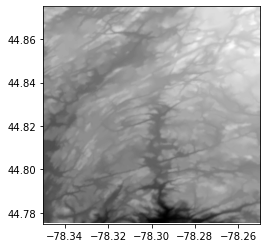

Convert to CGVD2013 successfully!


In [2]:
### convert to CGVD2013 
import numpy, rasterio
from rasterio.plot import show
%matplotlib inline

# load rasters
clipped_cdem = rasterio.open('Data/CDEM_mosaic_temp.tif')
clipped_byn = rasterio.open('Data/HT2_2010v70_CGG2013a_temp.tif')

clipped_cdem.meta
clipped_byn.meta

# do map algebra (band calculation)
delta_dem = clipped_byn.read(1)
cgvd1928 = clipped_cdem.read(1)
cgvd2013 = cgvd1928 - delta_dem/1000
cgvd2013 = numpy.where(cgvd2013 < -1000, -32767, cgvd2013)

# update the output tif metadata
cgvd2013_meta = clipped_cdem.meta.copy()
cgvd2013_meta.update({"compress":'lzw'})

# output the tif with cgvd2013 values
with rasterio.open('Data/CDEM_cgvd2013.tif', "w", **cgvd2013_meta) as dest:
    dest.write(cgvd2013.astype(rasterio.float32), 1)
    
# plot the cdem with CGVD2013
src = rasterio.open("Data/CDEM_cgvd2013.tif")
show(src,cmap='gray')
src.close()

print ("Convert to CGVD2013 successfully!")